In [1]:
import pickle
from pathlib import Path
import sys
sys.path.append("../..")
import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run


In [2]:
import neuralhydrology.datasetzoo.hysets as hs 
from neuralhydrology.utils.config import Config

cfg = Config(Path("hysets_basins.yml"))
boundaries = hs.load_hysets_boundaries(data_dir = cfg.data_dir)
boundaries =boundaries.loc[boundaries.Source == "HYDAT",:]
basins = boundaries.index.tolist()


attributes = hs.load_hysets_attributes(data_dir = cfg.data_dir, augmented=True)
#attributes = attributes.loc[basins,cfg.static_attributes]

idx = ~attributes.loc[basins,:].isna().any(axis=1)
basins = attributes.loc[idx,:].index.tolist()
attributes = attributes.loc[basins,:]

attributes_std = attributes.std()
nan_or_zero = attributes_std[~((attributes_std.isna()) | (attributes_std == 0))]
attributes = attributes.loc[:,nan_or_zero.index]



In [34]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import calendar
from tqdm import tqdm

def calc_fdc_slope(q):
    fdc = np.sort(q.dropna())[::-1]
    #exceedence_prob = np.arange(1, len(fdc) + 1) / (len(fdc) + 1)
    fdc_33 = np.percentile(fdc, 33)
    fdc_66 = np.percentile(fdc, 66)
    fdc_slope = (np.log(fdc_66) - np.log(fdc_33)) / (0.33)
    return fdc_slope


def sequence_duration(condition):
    """
    :param condition: A boolean array or pandas Series where True indicates the condition of interest.
    :type condition: pd.Series or np.ndarray
    :return: The average duration of consecutive True values in the input array. If there are no True values, returns 0.
    :rtype: float
    Example:
        >>> import numpy as np
        >>> condition = np.array([True, True, False, True, True, True, False])
        >>> sequence_duration(condition)
        2.0
    """
    condition = condition.values.flatten()
    if condition.sum() == 0:
        z = 0
    else:
        z = np.diff(np.where(np.concatenate(([condition[0]],condition[:-1] != condition[1:],[True])))[0])[::2].mean()
    return z


res = {}
filename = cfg.data_dir / "additional_attributes.txt"


for basin in tqdm(basins):
    x = dict()

    tt = hs.load_hysets_timeseries(data_dir=cfg.data_dir, basin=basin)


    frequency = "D"  # Daily frequency

    if frequency not in ["D", "H"]:
        raise ValueError("Unsupported frequency. Use 'D' for daily or 'H' for hourly.")



    if frequency == "D":
        hourly_multiplier = 1
    elif frequency == "H":
        hourly_multiplier = 24

    #def hystats(tt, area_km2=np.nan) -> dict:

    # tt.interpolate(method='linear', inplace=True)
    # tt = tt.loc[tt.first_valid_index():tt.last_valid_index(),:]
    tt = tt.ffill()
    tt = tt.dropna()
    #tt_interp = tt.copy()

    if frequency == "D":
        tt_daily = tt.copy()
    elif frequency == "H":
        tt_daily = pd.merge(tt.loc[:,[any(w in x for w in sum_params) for x in tt.columns]].resample('D').sum(min_count=12),
                        tt.loc[:,[all(w not in x for w in sum_params) for x in tt.columns]].resample('D').mean(),left_index=True,right_index=True)


    sum_params = ["total_precipitation"]




    #tt_daily_max = tt.resample('D').max()


    tt_monthly = pd.merge(tt.loc[:,[any(w in x for w in sum_params) for x in tt.columns]].resample('ME').sum(min_count=int(30 * 0.8 * hourly_multiplier)),
                    tt.loc[:,[all(w not in x for w in sum_params) for x in tt.columns]].resample('ME').mean(),left_index=True,right_index=True)


    #tt_monthly['PET(mm)'] = thornthwaite(tt_monthly['temperature(C)'], stations.loc[stn, 'Lat'])


    tt_annual = pd.merge(tt.loc[:,[any(w in x for w in sum_params) for x in tt.columns]].resample('YE').sum(min_count=int(365 * 0.8 * hourly_multiplier)),
                    tt.loc[:,[all(w not in x for w in sum_params) for x in tt.columns]].resample('YE').mean(),left_index=True,right_index=True)

    #for col in tt.columns:
    #    tt_col = tt[col].copy()
    #    tt_adjusted = tt_col[tt_col.first_valid_index():tt_col.last_valid_index()].copy()
    #    tt_adjusted.interpolate(method='linear', inplace=True)
    #    tt_col[tt_col.first_valid_index():tt_col.last_valid_index()] = tt_adjusted
    #    
    #    tt_interp[col] = tt_col
    #    del tt_col, tt_adjusted

    x['p_mean'] = tt_daily['total_precipitation'].mean()

    x['precip_high'] = x['p_mean'] * 5
    x['precip_low'] = 1

    x['precip_mean_monthly'] = tt_monthly['total_precipitation'].mean()#tt_interp['total_precipitation'].resample('ME').sum(min_count=25*24).mean()
    x['precip_mean_annual'] = tt_annual['total_precipitation'].mean()#tt_interp['total_precipitation'].resample('YE').sum(min_count=330*).mean()

    x['high_prec_freq'] = np.sum(tt_daily['total_precipitation'] > x['precip_high']) / len(tt_daily) / 365
    x['high_prec_dur'] = sequence_duration(tt_daily['total_precipitation'] > x['precip_high'])

    x['low_prec_freq'] = np.sum(tt_daily['total_precipitation'] < x['precip_low']) / len(tt_daily) / 365
    x['low_prec_dur'] = sequence_duration(tt_daily['total_precipitation'] < x['precip_low'])

    if tt["total_precipitation"].dropna().shape[0] >= 365*2.1 * hourly_multiplier:
        result = seasonal_decompose(tt['total_precipitation'].dropna(), model='additive', period=365 * hourly_multiplier)
        x['p_seasonality'] = np.array([0,1 - result.resid.var()/(result.seasonal + result.resid).var()]).max()
    else:
        x['p_seasonality'] = np.nan
        

    """
    bf = basestage_lyne_hollick(tt_daily.loc[:,'stage(m)'])
    x['basestage_index'] = np.mean(bf) / tt_daily.mean().values[0]


    x['stage_mean'] = tt_daily['stage(m)'].mean()
    x['stage_high'] = x['stage_mean'] * 9
    x['stage_low'] = x['stage_mean'] * 0.2

    x['high_stage_freq'] = np.sum(tt_daily['stage(m)'] > x['stage_high'])
    x['high_stage_dur'] = sequence_duration(tt_daily['stage(m)'] > x['stage_high'])

    x['low_stage_dur'] = sequence_duration(tt_daily['stage(m)'] < x['stage_low'])

    x['zero_stage_freq'] = np.sum(tt_daily['stage(m)'] == 0)

    x['stage95'] = tt_interp['stage(m)'].quantile(0.95)
    x['stage5'] = tt_interp['stage(m)'].quantile(0.05)

    result = adfuller(tt['stage(m)'].dropna())
    x['stage_adf'] = result[0]
    x['stage_adf_p'] = result[1]
    # x['stage_adf'] = result[0]
    # x['stage_adf'] = result[0]
    x['stage_adf_cv1'] = result[4]['1%']
    x['stage_adf_cv5'] = result[4]['5%']
    x['stage_adf_cv10'] = result[4]['10%']

    if tt['stage(m)'].dropna().shape[0] >= 365*24*4*2.1:
        result = seasonal_decompose(tt['stage(m)'].dropna(), model='additive', period=365*24*4)
        x['stage_seasonality'] = np.array([0,1 - result.resid.var()/(result.seasonal + result.resid).var()]).max()
    else:
        x['stage_seasonality'] = np.nan
    """


    x['q_mean'] = tt_daily['discharge'].mean()
    x['q_high'] = x['q_mean'] * 9
    x['q_low'] = x['q_mean'] * 0.2

    x['high_q_freq'] = np.sum(tt_daily['discharge'] > x['q_high']) / len(tt_daily) / 365
    x['high_q_dur'] = sequence_duration(tt_daily['discharge'] > x['q_high'])

    x['low_q_dur'] = sequence_duration(tt_daily['discharge'] < x['q_low'])
    x['zero_q_freq'] = np.sum(tt_daily['discharge'] == 0) / len(tt_daily) / 365


    x["fdc_slope"] = calc_fdc_slope(tt_daily['discharge'])


    x['q95'] = tt['discharge'].quantile(0.95)
    x['q5'] = tt['discharge'].quantile(0.05)

    #area_km2 = np.nan

    area_km2 = attributes.loc[basin,"Drainage_Area_km2"]
    area_m = area_km2 * 1000000
    tt["discharge(mm)"] = tt["discharge"] * 3600 * 24 * 1000 / area_m

    if area_km2 is not np.nan:   
        
        # select stage and precip
        qp = tt.loc[:,['discharge(mm)','total_precipitation']].copy()
        # remove timesteps with any nans
        #qp = qp.loc[np.all(~np.isnan(qp),axis=1),:]
        #qp['discharge'] = qp['discharge'] * 3600 * 24 * 1000 / area_m
        x['runoff_ratio'] = qp['discharge(mm)'].sum() / qp['total_precipitation'].sum()
        del qp

    #result = adfuller(tt['discharge'].dropna())
    #x['q_adf'] = result[0]
    #x['q_adf_p'] = result[1]
    # x['stage_adf'] = result[0]
    # x['stage_adf'] = result[0]
    #x['q_adf_cv1'] = result[4]['1%']
    #x['q_adf_cv5'] = result[4]['5%']
    #x['q_adf_cv10'] = result[4]['10%']


    #if tt['temperature(C)'].dropna().shape[0] >= 365*24*4*2.1:
    #    result = seasonal_decompose(tt['temperature(C)'].dropna(), model='additive', period=365*24*4)
    #    x['temp_seasonality'] = np.array([0,1 - result.resid.var()/(result.seasonal + result.resid).var()]).max()

    #else:
    #    x['temp_seasonality'] = np.nan


    tt_monthly['days_in_month'] = tt_monthly.index.map(lambda date: calendar.monthrange(date.year, date.month)[1])
    x["pet_mean"] = (tt_monthly['evaporation'].mean() / tt_monthly['days_in_month']).mean()

    x["aridity"] = x["pet_mean"] / x['precip_mean_monthly'] if x['precip_mean_monthly'] > 0 else np.nan
    x["frac_snow"] = tt["total_precipitation"].loc[tt["2m_tasmin"] < 0].sum() / tt["total_precipitation"].sum() if tt["total_precipitation"].sum() > 0 else np.nan
    tt["2m_tasmid"] = (tt['2m_tasmax'] + tt['2m_tasmax'])/2
    x['temp_mean'] = tt["2m_tasmid"].mean()
    res[basin] = x


    if basin == basins[0]:
        with open(filename, "w") as f:
            f.write("basin," + ",".join(x.keys()) + "\n")

    with open(filename, "a") as f:
        f.write(f"{basin}," + ",".join([str(x[k]) for k in x.keys()]) + "\n")


df_hydromet_attr = pd.DataFrame.from_dict(res, orient='index')

  1%|▏         | 32/2364 [05:12<6:12:38,  9.59s/it]C:\Users\everett\AppData\Local\Temp\ipykernel_12864\523106487.py:13: RuntimeWarning: divide by zero encountered in log
  fdc_slope = (np.log(fdc_66) - np.log(fdc_33)) / (0.33)
C:\Users\everett\AppData\Local\Temp\ipykernel_12864\523106487.py:13: RuntimeWarning: invalid value encountered in scalar subtract
  fdc_slope = (np.log(fdc_66) - np.log(fdc_33)) / (0.33)
 12%|█▏        | 294/2364 [50:22<6:19:05, 10.99s/it]C:\Users\everett\AppData\Local\Temp\ipykernel_12864\523106487.py:13: RuntimeWarning: divide by zero encountered in log
  fdc_slope = (np.log(fdc_66) - np.log(fdc_33)) / (0.33)
C:\Users\everett\AppData\Local\Temp\ipykernel_12864\523106487.py:13: RuntimeWarning: invalid value encountered in scalar subtract
  fdc_slope = (np.log(fdc_66) - np.log(fdc_33)) / (0.33)
 13%|█▎        | 316/2364 [54:18<6:05:48, 10.72s/it]C:\Users\everett\AppData\Local\Temp\ipykernel_12864\523106487.py:13: RuntimeWarning: divide by zero encountered in log


Drainage_Area_km2         13926.219136
Drainage_Area_GSIM_km2    13728.800631
Elevation_m                 534.402876
Slope_deg                     7.277016
Gravelius                     0.499620
Perimeter                   541.771093
Aspect_deg                   99.750108
Land_Use_Forest_frac          0.262835
Land_Use_Grass_frac           0.161817
Land_Use_Wetland_frac         0.046304
Land_Use_Water_frac           0.097875
Land_Use_Urban_frac           0.026061
Land_Use_Shrubs_frac          0.079078
Land_Use_Crops_frac           0.221669
Land_Use_Snow_Ice_frac        0.046979
Permeability_logk_m2          1.090696
Porosity_frac                 0.068689
p_mean                        1.018534
precip_high                   5.092671
precip_low                    0.000000
precip_mean_monthly          30.997450
precip_mean_annual          372.072886
high_prec_freq                0.000025
high_prec_dur                 0.068539
low_prec_freq                 0.000237
low_prec_dur             

In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



def cluster_basin_attribtues(attributes):
    #basins_with_qobs_camels = [basin for basin in merged_attributes.index if ~basin.startswith("0000HY")]


    # Select numeric columns for clustering
    numeric_columns = attributes.loc[:,:].select_dtypes(include=['float64']).columns
    data_for_clustering = attributes.loc[:, numeric_columns].dropna()

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_for_clustering)

    # Apply k-means clustering
    kmeans = KMeans(n_clusters=4, random_state=5)
    data_for_clustering['Cluster'] = kmeans.fit_predict(scaled_data)

    # Add cluster labels back to the original dataframe
    attributes.loc[data_for_clustering.index, 'Cluster'] = data_for_clustering['Cluster']

    selected_basins = []
    print(data_for_clustering["Cluster"].value_counts())
    for cluster in range(4):
        cluster_basins = data_for_clustering[data_for_clustering['Cluster'] == cluster].sample(n=64, random_state=0, replace=False).index.tolist()
        selected_basins.extend(cluster_basins)

    return selected_basins


selected_basins = cluster_basin_attribtues(attributes)
selected_basins

Cluster
0    239
1    182
2    158
3    110
Name: count, dtype: int64


c:\Users\everett\.conda\envs\neuralhydrology\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


['02VA001',
 '02QC017',
 '02OH008',
 '02PA006',
 '02PJ027',
 '08KE015',
 '02PG019',
 '05QA001',
 '02FF003',
 '02YK004',
 '02PC017',
 '02UC005',
 '08EE009',
 '02OG017',
 '02RH073',
 '02RC011',
 '02WA001',
 '02OJ007',
 '02WC002',
 '01BD004',
 '02HC011',
 '02OB037',
 '02OB033',
 '01AQ008',
 '01BH007',
 '01EN002',
 '02RE001',
 '01BF004',
 '02OJ023',
 '02PK009',
 '08HB074',
 '02PB033',
 '03AC001',
 '03AA002',
 '02FC016',
 '02XB002',
 '02RH056',
 '04JA002',
 '02LD005',
 '02OE027',
 '02LC025',
 '01BG008',
 '02QC007',
 '01BG003',
 '02JB003',
 '01BD002',
 '02YQ004',
 '02RH067',
 '02PL009',
 '02QC009',
 '04JC003',
 '02OD003',
 '02OA055',
 '01DH002',
 '02LG005',
 '02RE002',
 '02RH027',
 '02YN003',
 '02JB004',
 '04NB001',
 '08FC002',
 '02PJ028',
 '02YS001',
 '02OJ001',
 '06OA005',
 '05BH016',
 '05EC003',
 '07AG002',
 '11AD001',
 '10HB001',
 '04DC002',
 '08JC005',
 '05LL013',
 '05OF022',
 '04CE002',
 '07DA015',
 '10MB003',
 '07PB002',
 '10CD006',
 '08NM015',
 '07DC002',
 '07CD007',
 '05RD008',
 '09

In [27]:
attributes

,Drainage_Area_km2,Drainage_Area_GSIM_km2,Elevation_m,Slope_deg,Gravelius,Perimeter,Aspect_deg,Land_Use_Forest_frac,Land_Use_Grass_frac,Land_Use_Wetland_frac,...,low_q_dur,zero_q_freq,fdc_slope,q95,q5,runoff_ratio,pet_mean,aridity,frac_snow,temp_mean
01AD015,2712.0,2693.8140,293.3,4.4690,2.0620,381.994,223.9510,0.8207,0.0093,0.0032,...,26.355556,0.000000,1.845410,5.224779,0.205487,0.014251,-0.050892,-0.000522,0.380131,8.302056
01AH005,230.0,223.6040,339.3,5.9632,1.6687,88.559,224.0896,0.8220,0.1152,0.0023,...,10.384615,0.000000,0.000000,2.078296,0.290379,0.103691,-0.047811,-0.000486,0.419104,7.864427
01AJ011,156.0,155.5894,228.1,4.1180,1.4156,62.719,185.0623,0.5973,0.0844,0.0052,...,7.463918,0.000000,0.000000,3.007385,0.286338,0.224902,-0.051376,-0.000509,0.376063,9.378671
01AL008,641.0,640.7370,286.4,3.8236,1.8027,167.048,113.1216,0.8553,0.0486,0.0138,...,4.533333,0.000000,0.000000,3.154072,0.510852,0.053603,-0.050500,-0.000471,0.381544,9.779157
01AO009,93.2,109.5995,91.7,1.2917,1.8263,43.236,67.8626,0.9068,0.0227,0.0330,...,13.640000,0.000000,0.000000,4.018712,0.264206,0.594789,-0.056986,-0.000576,0.349787,10.938379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10PB001,19200.0,19988.6200,401.0,3.4809,6.1073,1012.309,25.4160,0.1021,0.3543,0.0043,...,49.600000,0.000000,2.388229,1.165500,0.130950,0.002036,-0.021371,-0.000672,0.495194,-6.296485
10PC001,2790.0,2742.8640,416.4,3.5192,2.7025,507.688,16.5893,0.0003,0.8163,0.0140,...,410.277778,0.001133,inf,1.174452,0.000000,0.009329,-0.018487,-0.000650,0.549422,-7.411146
10PC003,50700.0,50086.7300,428.0,4.1526,3.8438,2489.634,347.5413,0.0530,0.6299,0.0032,...,0.000000,0.000000,0.000000,0.294817,0.204497,0.000401,-0.020893,-0.000678,0.501313,-6.542104
11AB006,1970.0,1994.8220,1050.2,1.6712,1.6432,259.265,183.1435,0.0116,0.8704,0.0054,...,0.000000,0.000000,0.000000,0.004824,0.004824,0.000175,-0.045204,-0.001226,0.354844,10.080283


In [23]:
attributes.loc[basins,:]

,Watershed_ID,Source,Name,Centroid_Lat_deg_N,Centroid_Lon_deg_E,Drainage_Area_km2,Drainage_Area_GSIM_km2,Flag_GSIM_boundaries,Flag_Artificial_Boundaries,Elevation_m,...,Land_Use_Urban_frac,Land_Use_Shrubs_frac,Land_Use_Crops_frac,Land_Use_Snow_Ice_frac,Flag_Land_Use_Extraction,Permeability_logk_m2,Porosity_frac,Flag_Subsoil_Extraction,Hydrometric_station_latitude,Hydrometric_station_longitude
Official_ID,,,,,,,,,,,,,,,,,,,,,
01AD002,1,HYDAT,SAINT JOHN RIVER AT FORT KENT,47.25806,-68.59583,14703.9211,NaN,0,0,362.3,...,0.0089,0.0749,0.0242,0.0,0,-14.719327,0.180905,0,47.25806,-68.59583
01AD003,2,HYDAT,ST. FRANCIS RIVER AT OUTLET OF GLASIER LAKE,47.20661,-68.95694,1358.6435,NaN,0,0,353.4,...,0.0174,0.0410,0.0414,0.0,0,-14.056491,0.206450,0,47.20661,-68.95694
01AD015,3,HYDAT,MADAWASKA (RIVIERE) A 6 KM EN AVAL DU BARRAGE ...,47.53850,-68.59180,2712.0000,2693.8140,1,0,293.3,...,0.0230,0.0351,0.0600,0.0,0,-14.537390,0.165357,0,47.53850,-68.59180
01AE001,4,HYDAT,FISH RIVER NEAR FORT KENT,47.23750,-68.58278,2245.7638,NaN,0,0,276.5,...,0.0115,0.0641,0.0528,0.0,0,-14.687869,0.170597,0,47.23750,-68.58278
01AF006,5,HYDAT,BLACK BROOK NEAR ST-ANDRE-DE-MADAWASKA,47.09139,-67.73139,14.2000,NaN,0,1,201.8,...,0.0000,0.0000,1.0000,0.0,0,NaN,NaN,1,47.09139,-67.73139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11AC073,2371,HYDAT,DENNIEL CREEK EAST TRIBUTARY NEAR VAL MARIE,49.26167,-107.68190,118.0000,141.9198,1,0,863.2,...,0.0247,0.0020,0.5747,0.0,0,-16.222831,0.132237,0,49.26167,-107.68190
11AD001,2372,HYDAT,WHITEWATER CREEK NEAR INTERNATIONAL BOUNDARY,48.95000,-107.86670,3190.0000,3172.8450,1,0,902.8,...,0.0239,0.0089,0.6743,0.0,0,-16.035971,0.140816,0,48.95000,-107.86670
11AE006,2373,HYDAT,HORSE CREEK AT INTERNATIONAL BOUNDARY,48.98889,-106.83610,196.0000,193.7367,1,0,859.5,...,0.0016,0.0048,0.0569,0.0,0,-15.068687,0.177037,0,48.98889,-106.83610


In [3]:
date_ranges = {
    "train": slice(cfg.train_start_date, cfg.train_end_date),
    "validation": slice(cfg.validation_start_date, cfg.validation_end_date),
    "test": slice(cfg.test_start_date, cfg.test_end_date)
}


In [4]:

date_ranges
import pandas as pd


completeness = pd.DataFrame(columns=date_ranges.keys(), index=basins)

for basin in basins[:2]:
    df = hs.load_hysets_timeseries(data_dir=cfg.data_dir, basin=basin)
    for key in date_ranges.keys():
        completeness[basin, key] = (~df.loc[date_ranges[key]].isna().any(axis=1)).sum() / len(df)


        

In [23]:
import yaml

output_file = Path(f"{len(basins)}-hysets-basins.txt")

with open(output_file, "w") as file:
    file.write("\n".join(basins))
print(f"Saved {len(basins)} basins to {output_file}")

Saved 2364 basins to 2364-hysets-basins.txt


In [6]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
start_run(config_file=Path("hysets_basins.yml"))

2025-07-10 09:20:48,929: Logging to c:\Users\everett\Documents\GitHub\neuralhydrology\examples\07-Canada\runs\corrected_forcings_nse_1007_092048\output.log initialized.
2025-07-10 09:20:48,930: ### Folder structure created at c:\Users\everett\Documents\GitHub\neuralhydrology\examples\07-Canada\runs\corrected_forcings_nse_1007_092048
2025-07-10 09:20:48,931: ### Run configurations for corrected_forcings_nse
2025-07-10 09:20:48,931: experiment_name: corrected_forcings_nse
2025-07-10 09:20:48,932: train_basin_file: 256_clustered_basins.txt
2025-07-10 09:20:48,932: validation_basin_file: 256_clustered_basins.txt
2025-07-10 09:20:48,932: test_basin_file: 256_clustered_basins.txt
2025-07-10 09:20:48,933: train_start_date: 1982-10-01 00:00:00
2025-07-10 09:20:48,933: train_end_date: 2010-09-30 00:00:00
2025-07-10 09:20:48,934: validation_start_date: 1994-10-01 00:00:00
2025-07-10 09:20:48,934: validation_end_date: 2006-09-30 00:00:00
2025-07-10 09:20:48,935: test_start_date: 2006-10-01 00:00:

In [3]:
from neuralhydrology.datasetzoo import hysets

hysets_dir = Path(r"F:\Data\LSH\HYSETS_2023")
basins = hysets.load_hysets_attributes(data_dir=hysets_dir, metadata=True)
basins = basins.loc[basins["Source"] == "HYDAT",:].index.to_list()

In [4]:
basins

['01AD002',
 '01AD003',
 '01AD015',
 '01AE001',
 '01AF006',
 '01AF007',
 '01AF009',
 '01AH005',
 '01AJ003',
 '01AJ004',
 '01AJ006',
 '01AJ007',
 '01AJ010',
 '01AJ011',
 '01AK001',
 '01AK005',
 '01AK006',
 '01AK007',
 '01AL002',
 '01AL003',
 '01AL004',
 '01AL008',
 '01AM001',
 '01AN001',
 '01AN002',
 '01AO009',
 '01AP002',
 '01AP004',
 '01AP006',
 '01AP009',
 '01AQ001',
 '01AQ008',
 '01AR007',
 '01AR008',
 '01BA001',
 '01BC001',
 '01BD002',
 '01BD004',
 '01BD008',
 '01BD009',
 '01BE001',
 '01BF001',
 '01BF004',
 '01BG001',
 '01BG002',
 '01BG003',
 '01BG004',
 '01BG005',
 '01BG006',
 '01BG008',
 '01BG009',
 '01BH001',
 '01BH002',
 '01BH003',
 '01BH007',
 '01BH008',
 '01BH009',
 '01BH012',
 '01BJ001',
 '01BJ003',
 '01BJ007',
 '01BJ010',
 '01BJ012',
 '01BK006',
 '01BL001',
 '01BL002',
 '01BL003',
 '01BO001',
 '01BO003',
 '01BO004',
 '01BP001',
 '01BP002',
 '01BQ001',
 '01BS001',
 '01BT001',
 '01BU002',
 '01BU004',
 '01BU005',
 '01BU006',
 '01BU007',
 '01BU008',
 '01BU009',
 '01BV004',
 '01

In [5]:
from neuralhydrology.modelzoo import Config
import numpy as np
import pandas as pd
from tqdm import tqdm


cfg = Config(Path("hysets_basins.yml"))

availability_file = Path() / "data_availability2.csv"

if availability_file.exists():
    avail = pd.read_csv(availability_file, index_col=0)
else:
    prts = ['train','validation','test']
    avail = pd.DataFrame(index=basins, columns=prts)

    for basin in tqdm(basins):
        df = hysets.load_hysets_timeseries(data_dir=hysets_dir, basin=basin)
        for prt in prts:
            tr = slice(getattr(cfg,f'{prt}_start_date'),getattr(cfg,f'{prt}_end_date'))
            n = len(pd.date_range(start=tr.start, end=tr.stop, freq='D'))
            avail.loc[basin, prt] = 1 - df.loc[tr,:].resample("YE").mean().isnull().any(axis=1).mean()

    avail.to_csv(availability_file)

In [6]:
avail[(avail == 1).all(axis=1)].index.to_list()

['01AQ001',
 '01DR001',
 '01EC001',
 '01ED007',
 '01EE005',
 '01EF001',
 '01EO001',
 '01FA001',
 '01FB001',
 '01FB003',
 '02AD010',
 '02BB003',
 '02CF012',
 '02EA005',
 '02EB014',
 '02EC002',
 '02EC009',
 '02ED003',
 '02ED007',
 '02FA002',
 '02FB007',
 '02FB010',
 '02FE009',
 '02FF004',
 '02FF007',
 '02FF008',
 '02GA010',
 '02GC002',
 '02GC018',
 '02GD004',
 '02GD021',
 '02GG002',
 '02GG006',
 '02GG009',
 '02GH003',
 '02HA006',
 '02HB004',
 '02HB012',
 '02HC009',
 '02HC018',
 '02HC030',
 '02HC031',
 '02HC033',
 '02HD008',
 '02HD012',
 '02HJ001',
 '02HK007',
 '02HL003',
 '02HL004',
 '02HL005',
 '02HM004',
 '02HM005',
 '02KF011',
 '02LA007',
 '02LB008',
 '02MC001',
 '02OJ007',
 '02XA003',
 '02YO006',
 '02YQ001',
 '02YR001',
 '02YR003',
 '02ZF001',
 '02ZJ001',
 '03QC001',
 '03QC002',
 '04JC002',
 '05AA008',
 '05AA028',
 '05BG006',
 '05CB001',
 '05CB004',
 '05CG004',
 '05DC006',
 '05EB902',
 '05EC002',
 '05JA003',
 '05JB007',
 '05JC004',
 '05KH007',
 '05LA003',
 '05LD001',
 '05LH005',
 '05

In [7]:
basins = avail.index[np.all(avail > 0.99, axis=1)].to_list()

def list_to_txt(x:list, filename:Path, open_arg="w+"):
    
    output_file = open(filename, open_arg)
    for item in x:
        output_file.write(item + '\n')

basins = basins
list_to_txt(basins, f"{len(basins)}-hysets-basins.txt")

In [8]:
list_to_txt(hysets.load_hysets_attributes(data_dir=hysets_dir, augmented=False).columns.tolist(),hysets_dir.parent / "static_attributes.txt")

### Evaluate run on test set
The run directory that needs to be specified for evaluation is printed in the output log above. Since the folder name is created dynamically (including the date and time of the start of the run) you will need to change the `run_dir` argument according to your local directory name. By default, it will use the same device as during the training process.

In [9]:
run_dir = Path("runs/nse_ar_1811_054939")
eval_run(run_dir=run_dir, period="test", epoch=30)

2025-06-10 20:33:09,186: Using the model weights from runs\nse_ar_1811_054939\model_epoch030.pt


c:\Users\everett\Documents\GitHub\neuralhydrology\examples\07-Canada\../..\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model

# Evaluation:   0%|          | 0/445 [00:00<?, ?it/s]


FileNotFoundError:  Attribute file not found at C:\Users\everett\Documents\GitHub\canada_lsh\data\HYSETS\.HYSETS\HYSETS_watershed_properties.txt

### Load and inspect model predictions
Next, we load the results file and compare the model predictions with observations. The results file is always a pickled dictionary with one key per basin (even for a single basin). The next-lower dictionary level is the temporal resolution of the predictions. In this case, we trained a model only on daily data ('1D'). Within the temporal resolution, the next-lower dictionary level are `xr`(an xarray Dataset that contains observations and predictions), as well as one key for each metric that was specified in the config file.

In [ ]:
run_dir = Path("runs/nse_ar_1811_054939")

with open(run_dir / "test" / "model_epoch030" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['01AD003', '01AF007', '01AJ003', '01AJ004', '01AJ010', '01AK001', '01AK006', '01AK007', '01AL002', '01AL004', '01AM001', '01AN002', '01AP002', '01AP004', '01AQ001', '01BC001', '01BE001', '01BJ003', '01BJ007', '01BJ010', '01BL002', '01BL003', '01BO001', '01BP001', '01BQ001', '01BS001', '01BU002', '01BV006', '01CA003', '01DG003', '01DL001', '01DP004', '01DR001', '01EC001', '01ED007', '01EE005', '01EF001', '01EJ001', '01EO001', '01FA001', '01FB001', '01FB003', '01FJ002', '02AB008', '02AB017', '02AC001', '02AC002', '02AD010', '02BA003', '02BB003', '02BF001', '02BF002', '02BF004', '02CA002', '02CB003', '02CD006', '02CF007', '02CF008', '02CF012', '02DD013', '02DD014', '02DD015', '02EA005', '02EA010', '02EB014', '02EC002', '02EC009', '02ED003', '02ED007', '02FA002', '02FB007', '02FB010', '02FE009', '02FF004', '02FF007', '02FF008', '02GA010', '02GA018', '02GC002', '02GC018', '02GD004', '02GD021', '02GE005', '02GG002', '02GG006', '02GG009', '02GH003', '02HA006', '02HB004', '02HB012',

results.keys()[0]

The data variables in the xarray Dataset are named according to the name of the target variables, with suffix `_obs` for the observations and suffix `_sim` for the simulations.

In [ ]:
list(results.keys())[0]

'01AD003'

Let's plot the model predictions vs. the observations

<xarray.DataArray 'q(mm/d)_obs' (date: 4383, time_step: 1)>
array([[       nan],
       [0.6258011 ],
       [0.6220536 ],
       ...,
       [0.0861882 ],
       [0.11616671],
       [0.16862905]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 1982-10-01 1982-10-02 ... 1994-09-30
  * time_step  (time_step) int64 0

Text(0.5, 1.0, 'Test period - NSE 0.931')

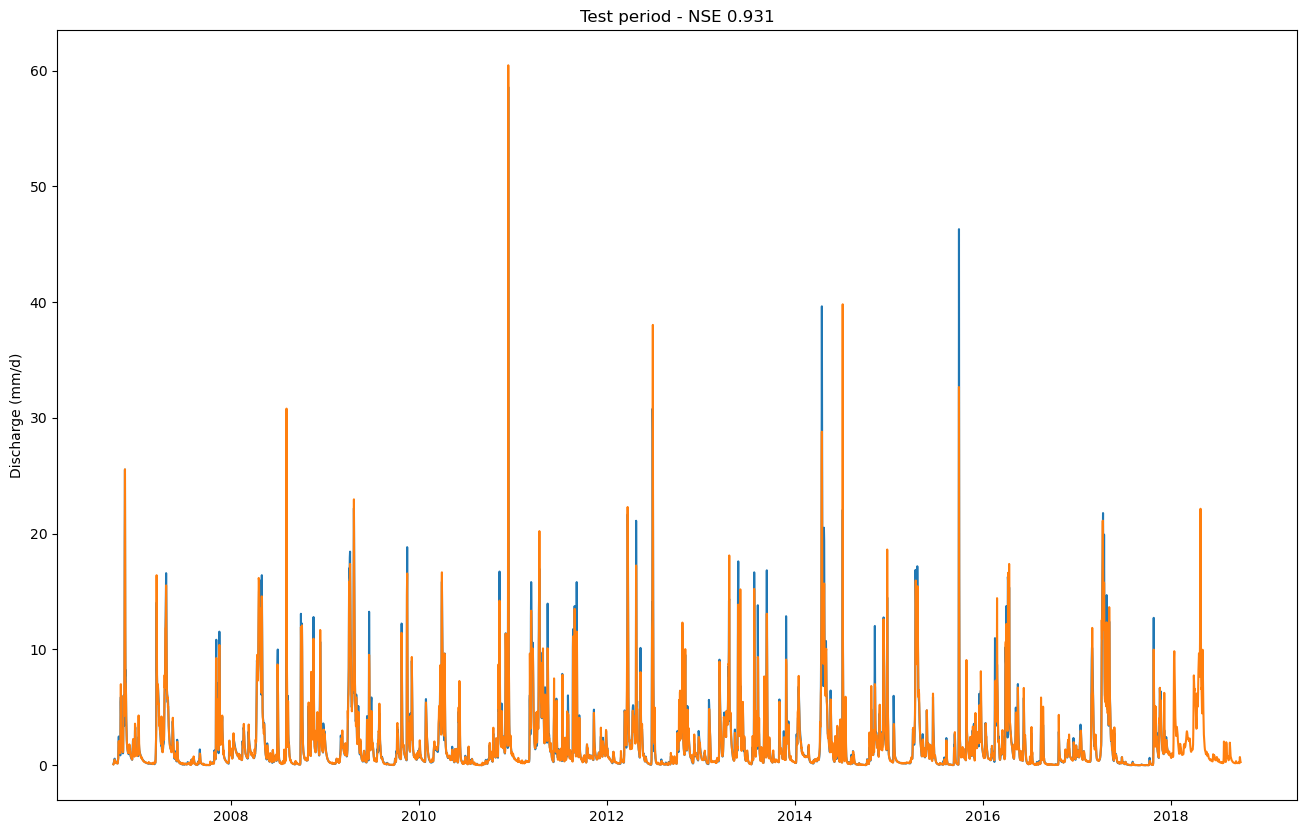

In [ ]:
# extract observations and simulations
qobs = results['01AK007']['1D']['xr']['q(mm/d)_obs']
qsim = results['01AK007']['1D']['xr']['q(mm/d)_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs['date'], qobs)
ax.plot(qsim['date'], qsim)
ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['01AK007']['1D']['NSE']:.3f}")

Next, we are going to compute all metrics that are implemented in the NeuralHydrology package. You will find additional hydrological signatures implemented in `neuralhydrology.evaluation.signatures`.

In [ ]:
values = metrics.calculate_all_metrics(qobs.isel(time_step=-1), qsim.isel(time_step=-1))
for key, val in values.items():
    print(f"{key}: {val:.3f}")

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\01-Introduction\../..\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\everett\Documents\GitHub\neuralhydrology\examples\01-Introduction\../..\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


NSE: 0.803
MSE: 0.968
RMSE: 0.984
KGE: 0.871
Alpha-NSE: 0.936
Beta-KGE: 1.044
Beta-NSE: 0.040
Pearson-r: 0.898
FHV: -8.186
FMS: -5.655
FLV: -268.469
Peak-Timing: 0.130
Peak-MAPE: 29.906
